In [1]:
import os 
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/home/st/st_st/st_st163811/workspace/vle_using_solvation_free_energy")
from tools.reader import get_dh_dl, get_data


from botorch import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.utils.transforms import normalize, unnormalize
from botorch.optim.optimize import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.models.transforms.outcome import Standardize
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement, qExpectedImprovement
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood


from utils_automated import get_new_lambdas, train_gpr, get_partial_uncertanty, get_rmsd, estimate_variance

tkwargs = {
    "dtype": torch.double,
    "device": "cpu"
}

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


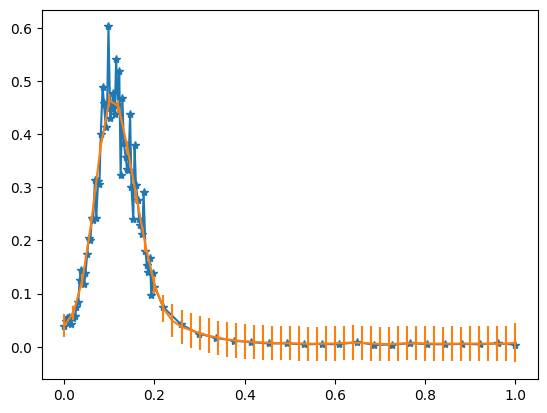

In [2]:
data_output = "./lammps/hexane_hexane/reference_sim/sim_%d/fep%d%d.sampling"

idx_sim_folder = np.arange(0,81,1)
paths     = [data_output%(i,i,i+1) for i in idx_sim_folder]
lambdas   = np.round( np.concatenate( (np.linspace(0,0.2,60), np.linspace(0.22,1.0,21)) ), 3 )
mean, var = get_dh_dl( fe_data = [get_data(paths)], no_intermediates = len(lambdas), delta = 0.0001 , both_ways = False)

train_X    = torch.tensor(lambdas, **tkwargs).reshape(-1,1)
train_Y    = torch.tensor(mean, **tkwargs).reshape(-1,1)
train_Yvar = torch.tensor(var, **tkwargs).reshape(-1,1)

# Construct GP and optimize hyperparameters for training data
var_gpr = SingleTaskGP(train_X, train_Yvar, outcome_transform=Standardize(m=1) )
mll_var   = ExactMarginalLogLikelihood( var_gpr.likelihood, var_gpr)
fit_gpytorch_mll( mll_var )

test_X    = torch.linspace(0,1,51).reshape(-1,1)

# Predict new data
# torch.no_grad() speeds up computation as we dont evaluate gradients
with torch.no_grad():
    var_gpr.eval()  # Set the model to evaluation mode
    posterior = var_gpr.posterior(test_X)
    mean_prediction = posterior.mean
    variance_prediction = posterior.variance

plt.plot(train_X.flatten(),train_Yvar.flatten(),marker="*")
plt.errorbar(test_X.flatten(),mean_prediction.flatten(),torch.sqrt(variance_prediction).flatten())
plt.show()
plt.close()

## Constraints in botorch:

1) Parameter constraints are constraints on the input space that restrict the values of the generated candidates. These are passed to "optimize_acqf"

2) Outcome constraints usually mean constraints on a (black-box) outcome that needs to be modeled, just like the objective function is modeled by a surrogate model. (e.g.: that f(x) - 0.5 < 0.0 )

In [3]:
def initialize_model( train_x, train_obj, bounds ):
    train_x = normalize(train_x, bounds)
    model = SingleTaskGP(train_x, train_obj, outcome_transform=Standardize(m=1) )
    mll   = ExactMarginalLogLikelihood( model.likelihood, model)
    return mll, model

def initialize_model_obj_constraint(train_x, train_obj, train_con, bounds):
    # define models for objective and constraint
    train_x = normalize(train_x, bounds)
    train_y = torch.cat([train_obj, train_con], dim=-1)
    models = []
    for i in range(train_y.shape[-1]):
        models.append(
            SingleTaskGP(
                train_x, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)
            )
        )
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    return mll, model


def optimize_acqf_and_get_observation(acq_func, batch_size, bounds, min_difference: float=1e-3):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # batch_size defines the number of batches of possible new candidates.
    # optimize

    # Constraint that candidates must be ascending sorted --> thus they have to be at least differenciated by "min_difference"
    # This is also used to determine how many decimals the lambda points will have. If a difference of 0.01 is enforced, I can 
    # just use lambda points with 2 decimals.
    asc_sort_constraints = [ ( torch.tensor([i,i+1],dtype=torch.int), torch.tensor([-1,1],**tkwargs), min_difference ) for i in range(bounds.shape[-1]-1) ]
    
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=batch_size,
        inequality_constraints=asc_sort_constraints,
        num_restarts=10,
        raw_samples=512,
        options={"batch_limit": 5, "maxiter": 200}, 
    )

    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=bounds)

    # Submit simulations and gather new objective
    # Here just use trained GPR to predict the variance
    obj = []

    for x in new_x:

        posterior  = var_gpr.posterior( x )
        train_yvar = posterior.mean
        std_dG_i   = get_partial_uncertanty( x.tolist(), train_yvar.tolist() )
        std_dG_opt = np.sum( std_dG_i ) / ( len(x) - 1 )
        rmsd       = np.sqrt( np.mean( (np.array(std_dG_i) - std_dG_opt)**2 ) ) / std_dG_opt
        obj.append([rmsd])
        
        print(f"\ncandidate: {', '.join(['%.3f'%i for i in x]) }\nRMSD: {rmsd}\n")

    new_obj = -1* torch.tensor(obj, **tkwargs)

    return new_x, new_obj

In [5]:
#from botorch.acquisition import GenericMCObjective
#generic_objective = GenericMCObjective( lambda Z: Z[..., 0] )

In [5]:
# Get initial data
train_x   = []
train_obj = []

N_intermediates = 11

for i in range(24):
    t_x = torch.cat([torch.tensor([0.],**tkwargs), torch.rand(N_intermediates-2,**tkwargs), torch.tensor([1.],**tkwargs)]).sort().values
    t_y = abs( var_gpr.posterior(t_x).mean )
    std_dG_i = get_partial_uncertanty( t_x.tolist(), t_y.tolist() )
    
    std_dG_opt = np.sum( std_dG_i ) / ( N_intermediates - 1 )
    rmsd       = np.sqrt( np.mean( (np.array(std_dG_i) - std_dG_opt)**2 ) ) / std_dG_opt

    train_x.append( t_x )
    train_obj.append( torch.tensor([rmsd],**tkwargs) )

train_x    = torch.stack(train_x)
train_obj  = -1 * torch.stack(train_obj)

# Set boundaries for all intermediates
bounds = torch.zeros(2,N_intermediates, **tkwargs)
bounds[1] = 1.0

# constrain first and last to stick to 0 and 1
bounds[0][-1] = 0.9999
bounds[1][0]  = 0.0001

# initialize model
mll, model = initialize_model( train_x, train_obj, bounds )

# Define number of iterations
N_ITERATION = 20
N_CANDIDATES_PER_ITERATION = 5

# run N_ITERATION rounds of BayesOpt after the initial random batch
for iteration in range(1, N_ITERATION + 1):

    # fit the model
    fit_gpytorch_mll(mll)

    qNEI = qNoisyExpectedImprovement(
        model=model,
        X_baseline=normalize(train_x, bounds),
        sampler=SobolQMCNormalSampler(sample_shape=torch.Size([128])),
    )

    # optimize and get new observation
    new_x, new_obj = optimize_acqf_and_get_observation(qNEI, N_CANDIDATES_PER_ITERATION, bounds)

    # update training points
    train_x    = torch.cat([train_x, new_x])
    train_obj  = torch.cat([train_obj, new_obj])

    # reinitialize the models so they are ready for fitting on next iteration
    mll, model = initialize_model( train_x, train_obj, bounds )

    print( f"Iteration {iteration:>2}: best_value = {new_obj.max():>4.2f}\n" )



candidate: 0.000, 0.001, 0.002, 0.003, 0.004, 0.406, 0.786, 0.787, 0.788, 0.919, 1.000
RMSD: 2.1586073911722083


candidate: 0.000, 0.025, 0.325, 0.326, 0.688, 0.689, 0.690, 0.691, 0.692, 0.860, 1.000
RMSD: 1.816661974515892


candidate: 0.000, 0.001, 0.052, 0.053, 0.459, 0.500, 0.653, 0.654, 0.655, 0.999, 1.000
RMSD: 2.3042025649179845


candidate: 0.000, 0.001, 0.161, 0.162, 0.291, 0.292, 0.619, 0.620, 0.714, 0.999, 1.000
RMSD: 1.3087066713506228


candidate: 0.000, 0.055, 0.205, 0.206, 0.207, 0.302, 0.340, 0.643, 0.792, 0.897, 1.000
RMSD: 1.720523986302461

Iteration  1: best_value = -1.31


candidate: 0.000, 0.001, 0.473, 0.474, 0.544, 0.716, 0.717, 0.718, 0.719, 0.720, 1.000
RMSD: 2.211947325773972


candidate: 0.000, 0.001, 0.002, 0.280, 0.281, 0.282, 0.283, 0.534, 0.566, 0.567, 1.000
RMSD: 1.5754446650897334


candidate: 0.000, 0.001, 0.002, 0.407, 0.408, 0.409, 0.439, 0.440, 0.721, 0.722, 1.000
RMSD: 2.19398783393216


candidate: 0.000, 0.349, 0.352, 0.401, 0.563, 0.564, 0.565

In [6]:
# Get initial data
train_x   = []
train_obj = []

N_intermediates = 11

for i in range(24):
    t_x = torch.cat([torch.tensor([0.],**tkwargs), torch.rand(N_intermediates-2,**tkwargs), torch.tensor([1.],**tkwargs)]).sort().values
    t_y = abs( var_gpr.posterior(t_x).mean )
    std_dG_i = get_partial_uncertanty( t_x.tolist(), t_y.tolist() )
    
    std_dG_opt = np.sum( std_dG_i ) / ( N_intermediates - 1 )
    rmsd       = np.sqrt( np.mean( (np.array(std_dG_i) - std_dG_opt)**2 ) ) / std_dG_opt

    train_x.append( t_x )
    train_obj.append( torch.tensor([rmsd],**tkwargs) )

train_x    = torch.stack(train_x)
train_obj  = -1 * torch.stack(train_obj)

# Set boundaries for all intermediates
bounds = torch.zeros(2,N_intermediates, **tkwargs)
bounds[1] = 1.0

# constrain first and last to stick to 0 and 1
bounds[0][-1] = 0.9999
bounds[1][0]  = 0.0001

# initialize model
mll, model = initialize_model( train_x, train_obj, bounds )

# Define number of iterations
N_ITERATION = 80
N_CANDIDATES_PER_ITERATION = 5

print( f"Iteration 0: best_value = {train_obj.max():>4.2f}\n" )

best_list = [ train_obj.max() ]

# run N_ITERATION rounds of BayesOpt after the initial random batch
for iteration in range(1, N_ITERATION + 1):

    # fit the model
    fit_gpytorch_mll(mll)

    qNEI = qExpectedImprovement(
        model=model,
        best_f=train_obj.max(),
        sampler=SobolQMCNormalSampler(sample_shape=torch.Size([128])),
    )

    # optimize and get new observation
    new_x, new_obj = optimize_acqf_and_get_observation(qNEI, N_CANDIDATES_PER_ITERATION, bounds)

    # update training points
    train_x    = torch.cat([train_x, new_x])
    train_obj  = torch.cat([train_obj, new_obj])

    # reinitialize the models so they are ready for fitting on next iteration
    mll, model = initialize_model( train_x, train_obj, bounds )

    print( f"Iteration {iteration:>2}: best_value = {new_obj.max():>4.2f}\n" )
    best_list.append( new_obj.max() )


Iteration 0: best_value = -0.95


candidate: 0.000, 0.234, 0.235, 0.236, 0.237, 0.427, 0.442, 0.756, 0.898, 0.999, 1.000
RMSD: 1.9614068169869536


candidate: 0.000, 0.147, 0.148, 0.149, 0.150, 0.302, 0.410, 0.818, 0.958, 0.966, 1.000
RMSD: 1.4790975570201603


candidate: 0.000, 0.003, 0.205, 0.368, 0.369, 0.494, 0.495, 0.555, 0.556, 0.873, 1.000
RMSD: 1.4078935735282323


candidate: 0.000, 0.160, 0.209, 0.228, 0.264, 0.640, 0.641, 0.642, 0.643, 0.910, 1.000
RMSD: 1.9893691391207144


candidate: 0.000, 0.206, 0.207, 0.208, 0.460, 0.461, 0.559, 0.588, 0.589, 0.839, 1.000
RMSD: 1.712011027722518

Iteration  1: best_value = -1.41


candidate: 0.000, 0.109, 0.581, 0.700, 0.701, 0.702, 0.793, 0.836, 0.998, 0.999, 1.000
RMSD: 1.783800307358839


candidate: 0.000, 0.221, 0.527, 0.634, 0.635, 0.636, 0.637, 0.931, 0.998, 0.999, 1.000
RMSD: 1.7588333089742294


candidate: 0.000, 0.229, 0.351, 0.816, 0.817, 0.818, 0.819, 0.822, 0.998, 0.999, 1.000
RMSD: 2.5041011951352012


candidate: 0.000, 0.18

In [10]:
max(best_list)

tensor(-0.6141, dtype=torch.float64)

In [ ]:
candidate: 0.000, 0.064, 0.087, 0.114, 0.180, 0.254, 0.314, 0.415, 0.490, 0.698, 1.000
RMSD: 0.5754350141163816